In [30]:
import math

In [31]:
class Value:
    def __init__(self, data, _operation = "", _children = (), label = ""):
        self.data = data
        self._prev = set(_children)
        self._operation = _operation
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        operation = " add "
        children = (self, other)
        addition = self.data + other.data
        result = Value(data = addition, _operation = operation, _children = children)

        def _backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad

        self._backward = _backward
            
        
        return result

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        operation = " mul "
        children = (self, other)
        addition = self.data * other.data
        result = Value(data = addition, _operation = operation, _children = children)
        
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad

        self._backward = _backward        
        
        return result

    def __rmul__(self, other):
        return self * other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __neg__(self):
        return -1 * self

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "power can be integer or float"
        operation = f" pow({other})"
        children = (self, )
        power = self.data ** other
        result = Value(data = power, _children = children, _operation = operation)
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * result.grad

        self._backward = _backward        
        
        return result

    def __truediv__(self, other):
        return self * (other ** -1)

    def __rtruediv__(self, other):
        return other * (self ** -1)

    def exp(self):
        operation = " exp "
        children = (self, )
        e = math.exp(self.data)
        result = Value(data = e, _operation = operation, _children = children)

        def _backward():
            self.grad += self.data * result.grad

        self._backward = _backward
        
        return result

    def tanh(self):
        x = self.data
        operation = " tanh "
        children = (self, )
        tan_h = (math.exp(2.0 * x) - 1.0) / (math.exp(2.0 * x) + 1.0)
        result = Value(data = tan_h, _operation = operation, _children = children)
        
        def _backward():
            self.grad += (1 - tan_h**2) * result.grad

        self._backward = _backward        
        
        return result

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [32]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
    if n._operation:
      dot.node(name = uid + n._operation, label = n._operation)
      dot.edge(uid + n._operation, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot

In [33]:
x1 = Value (2.0, label='x1') 
x2 = Value(0.0, label='x2')

w1 = Value (-3.0, label='w1')
w2 = Value (1.0, label='w2')

b = Value (6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*wl' 
x2w2 = x2*w2; x2w2.label = 'x2*w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' 
n = x1w1x2w2 + b; n. label = 'n'

o = n.tanh()
o.backward() 

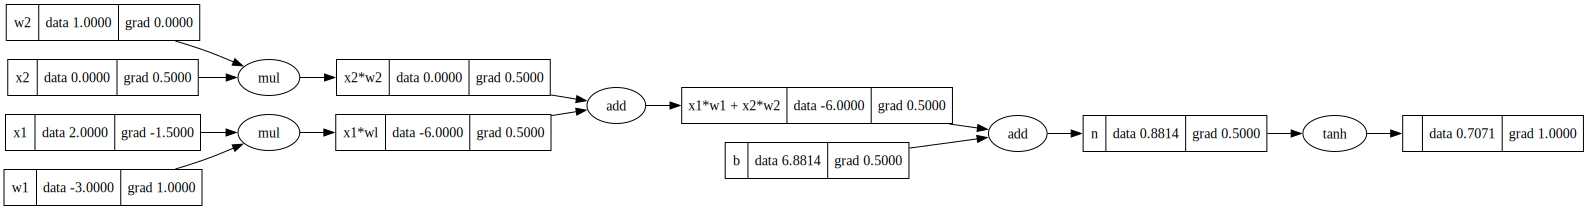

In [34]:
draw_dot(o)